##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


Pada project ini dilakukan implementasi terhadap model pre-trained
pre-trained meruapakan sebuah model yang tersimpan dalam sebuah jaringan sebelumnya yang dilatih dengan menggunakan kumpulan data yang besar untuk sebuah klasfikasi pada gambar dengan skala yang besar.

Latar belakang dari proses transfer learning pada klasifikasi gambar yaitu pemodelan ini dapat diguanakn untuk data yang besar dan efektif berfungsi pada data visual. Transfer learning memudahkan untuk memanfaatkan beberapa fitur untuk dipelajari dalam model tanpa harus memulai dari awal pemodelan yang besar.

Terdapat dua cara untuk menyesuaikan model yang telah dilatih:

Feature Extraction : yaitu penggunaan representasi yang dipelajari pada model jaringan sebelumnya untuk mengekstrak fitur untuk mendapatkan sampel baru. Cara kerjanya dengan menambahkan pengklasifikasi baru, yang akan dilatih dari awal, di atas model yang telah dilatih sebelumnya sehingga model dapat menggunakan kembali peta fitur yang dipelajari sebelumnya untuk kumpulan data.

Fine-Tuning: Mencairkan beberapa lapisan atas dari basis model yang dibekukan dan bersama-sama melatih lapisan pengklasifikasi yang baru ditambahkan dan lapisan terakhir dari model dasar. Ini memungkinkan kita untuk "menyempurnakan" representasi fitur tingkat tinggi dalam model dasar agar lebih relevan untuk tugas tertentu.

Proses dalam membuat transfer learning model yaitu :
Examine and understand the data
Build an input pipeline, in this case using Keras ImageDataGenerator
Compose the model
Load in the pretrained base model (and pretrained weights)
Stack the classification layers on top
Train the model
Evaluate model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

Pada tulisan ini data diambil dari ribuan gambar dari kuncing dan anjing, data di didownkload dan dieksktrak, lalu dibuat tf.data.Dataset untuk melakukan pelatihan dan validasi data menggunakan tf.keras.utils.image_dataset_from_director

Download dan ekstrak data dan membuat train dataset dengan tf.keras.utils.image_dataset_from_director

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


Membuat validation data test menggunakan 
tf.keras.utils.image_dataset_from_director

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

Menampikan datatest

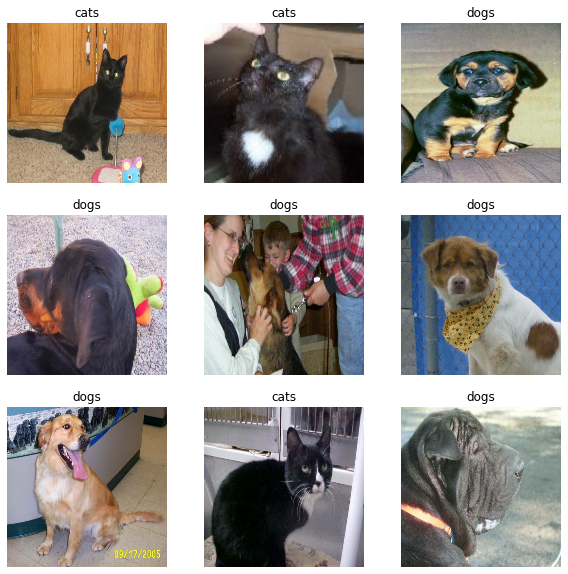

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

Dalam dataset tidak terdsedia sebuah set untuk test data sehingga diperlukan pembuatan batch data test menggunakan tf.data.experimental.cardinalit dan mengambil sebesar 20% dari data train ke data test

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

Gunakan buffered prefetching untuk memuat gambar dari disk tanpa emblokiran input dan output

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

Ketika tidak mendaatkan sebuah dataset gambar yang besar, maka dapat digunakan artificial learning untuk menambahkan dataset dengan melakukan transformasi data train dengan memutar atau membalikan gambar. Hal ini memberikan manfaat untuk mengekspos model ke berbagai aspek rasio data pelatihan dan mengurangi overfitting.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

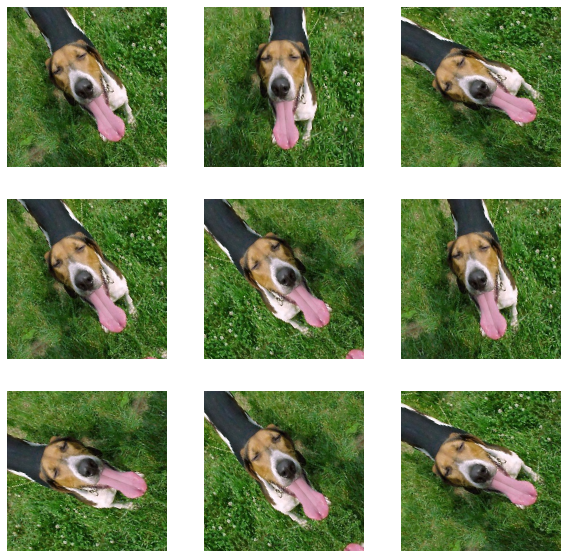

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Visulasi dari model augmentation pada data yang dirotasikan

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

Melakukan rescalae pada nilai pixel menggunakan MobileNetV2 sebagai basis model dengan ekspektasi nilai [-1,1] namun data gambar yang dimiliki memilii [0,255], maka dalam hal ini digunakan prerprosesing metode yang inlcude dalam model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

Melakukan rescaling dengan pembagian dua dari bentuk pixel

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

Pembuata model pre-trained menggunakan model MobileNet V2 yang dikelola oleh google meruapakan sebuah pretrained model yag dibentuk pada dataset ImageNet terdiri dari 1.4M gambar dan 1000 kelas.

Untuk menggunakan model ini maka hal pertama yang harus dilakukan yaitu dengan mengekstrak fitur dengan prinsip Fitur lapisan bottleneck yaitu mempertahankan lebih umum dibandingkan dengan lapisan akhir/atas.

Pertama, buat instance model MobileNet V2 yang telah dimuat sebelumnya dengan bobot yang dilatih di ImageNet. Dengan menentukan argumen include_top=False, Anda memuat jaringan yang tidak menyertakan lapisan klasifikasi di bagian atas, yang ideal untuk ekstraksi fitur.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

Dalam melakukan percobaan ekstrasi fitur hanya dapat dilakukan pada layer atas dalam model dasar MobileNetV2, bobot jaringan dalam pretrained tidak diperbarui selama pelatihan.

Cara untuk mendapatkan performa lebih yaitu dengan mengubnbobot lapisan atas model yang telah dilatih sebelumnya di samping pelatihan pengklasifikasi yang Anda tambahkan. Proses pelatihan akan memaksa bobot untuk disetel dari peta fitur generik ke fitur yang terkait secara khusus dengan kumpulan data.

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

Dalam tahap ekstraksi fitur, maka dilakukan pembekuan basis konvolusi yang dibuat dari langkah sebelumnya dan digunakan sebagai ekstraktor fitur. Selain itu, Anda menambahkan pengklasifikasi di atasnya dan melatih pengklasifikasi tingkat atas.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

Penting untuk membekukan convlutional basis sebelum mengkompile dan melatih model dengan (setting.layer.trainable =False) untuk menghindari beban dalam pemberian layer dari update setelah pelatihan. MobileNet V2 memiliki banyak lapisan, maka atur model flag ke Falsse

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

Kebanyakan dari BatchNormalization layer digunakan dalam pemodelan karena lapisan ini memiliki spesialisasi dalam sebuah case dan peringatan terhadap sesuatu yang harus diambil dalam konteks fine tuning

Ketika melakukan set layer.trainabel = False, BatchNormalization layer akan berjalan dalam infrence mode dan tidak akan update jika rata2 dan variansi data statistik tidak diupdate

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

untuk mengenarate prediksi dari fitur blok, rata2 spasialnya sebesar 5x5, penggunaan globalAveragePooling2D pada lapisan memberikan konversi kedalam elemen tunggal sebanyak 1280 vektor per gambar

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

Aplikasikan tf.keras.layers.Dense pada lapisanm untuk mengkonvert fitur ke dalam satu prediksi per gambar. tidak perlu melakukan aktivasi fungsi karena prediksi ini akan diperlakukan sebagai logit, atau nilai prediksi mentah. Angka positif memprediksi kelas 1, angka negatif memprediksi kelas 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

Pembuatan model dengan menyatukan data augmentasi, rescale, base model dan ekstraksi layer menggunakan keras functional API dengan training = False pada model lapisan BatchNormalization

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

Melakukan complie pada model sebelum dilatih, terdapat penggunaan kelas yaitu BinaryCrossentropy dan loss calculation dengan from_logits = True untuk mendapatkan linear output

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model dicompile menggunakan Adam optimizer dengan basis rate learning rate dan loss control dengan BinaryCrosentropy dan pengukuran metriks akurasi

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

Sebanyak 2.5M paramater dalam MobileNet dibekukan namun terdapat 1.2K trainable parameter pada lapisan Dense. Hal ini terbagi diantara tf.Variabel pada object, beban dan bias

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 55ms/step - loss: 0.6873 - accuracy: 0.5681


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.57


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 88ms/step - loss: 0.6510 - accuracy: 0.6070 - val_loss: 0.4742 - val_accuracy: 0.7389
Epoch 2/10
63/63 [==============================] - 6s 87ms/step - loss: 0.4885 - accuracy: 0.7265 - val_loss: 0.3378 - val_accuracy: 0.8391
Epoch 3/10
63/63 [==============================] - 6s 89ms/step - loss: 0.3978 - accuracy: 0.8040 - val_loss: 0.2684 - val_accuracy: 0.8911
Epoch 4/10
63/63 [==============================] - 6s 88ms/step - loss: 0.3470 - accuracy: 0.8385 - val_loss: 0.2192 - val_accuracy: 0.9319
Epoch 5/10
63/63 [==============================] - 6s 88ms/step - loss: 0.2942 - accuracy: 0.8650 - val_loss: 0.1854 - val_accuracy: 0.9455
Epoch 6/10
63/63 [==============================] - 6s 89ms/step - loss: 0.2718 - accuracy: 0.8815 - val_loss: 0.1680 - val_accuracy: 0.9394
Epoch 7/10
63/63 [==============================] - 6s 89ms/step - loss: 0.2465 - accuracy: 0.8915 - val_loss: 0.1463 - val_accuracy: 0.9468
Epoch 8/10
63

Pada model fit dilakukan perulangan epocs sebanyak 10 kali dengan melakukan training data berupa(loss dan accuracy) dan validasi uji traning data(val_loss dan val-accuracy)

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

Untuk melihat bagaiaman kurva dari traning dan validation akurasi/loss pada MobileNet V2 sebagai perbaikan fitur ekstraktor

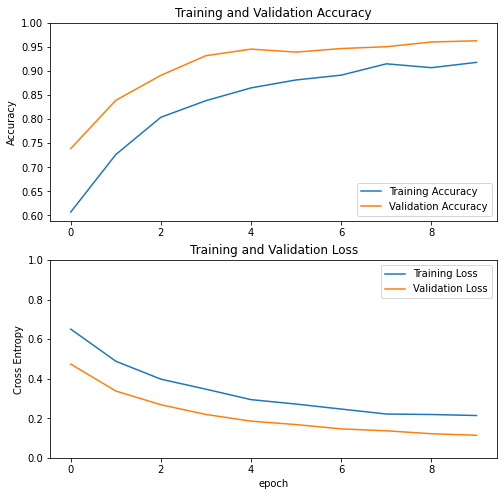

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

Validasi metriks memliki nilai yang lebih baik dengan trainig matriks karena faktor utama yaitu lapisan seperti BatchNormalization dan Dropout akurasi terpengaruh setelah proses training. faktor itu di matikan ketika melakukan kalkulasi validasi loss.

Pada tingkat yang lebih rendah, ini juga karena metrik pelatihan melaporkan rata-rata untuk suatu epoch, sedangkan metrik validasi dievaluasi setelah epoch, sehingga metrik validasi melihat model yang telah dilatih sedikit lebih lama.


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

Mencarikan base_model dan set lapisan bawah untuk untrainable, dan melakukan recompile pada model untuk melihat perubahan yang akan terjadi serta meresume hasil traning 

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


Melihat seberapa banyak layers dalam bas model, melakukan inisiasi pada fine tuning dan membekukan layer sebelumya sebelum layer ditambahkan

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

Ketika melatih model lebih besar dan ingin melakukan readapt terhadap beban pada pretrained, penting untuk menggunkaan learning rate yang rendah pada tahap ini. Atau model akan terjadi overfit dengan cepat

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

Melanjutkan pemodelan traning dengan melanjutkan epocs sebelum lapisan model yang dibekukan sebanyak 10 untuk meningkatakan akurasi untuk beberapa poin persentase

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 15s 132ms/step - loss: 0.1492 - accuracy: 0.9370 - val_loss: 0.0562 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 8s 116ms/step - loss: 0.1152 - accuracy: 0.9515 - val_loss: 0.0464 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 8s 119ms/step - loss: 0.1086 - accuracy: 0.9555 - val_loss: 0.0394 - val_accuracy: 0.9864
Epoch 13/20
63/63 [==============================] - 8s 116ms/step - loss: 0.0921 - accuracy: 0.9580 - val_loss: 0.0800 - val_accuracy: 0.9703
Epoch 14/20
63/63 [==============================] - 8s 117ms/step - loss: 0.0874 - accuracy: 0.9650 - val_loss: 0.0415 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 8s 116ms/step - loss: 0.0860 - accuracy: 0.9660 - val_loss: 0.0368 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 8s 116ms/step - loss: 0.0812 - accuracy: 0.9695 - val_loss: 0.0386 - val_accuracy: 0.983

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


Setetlah model epoksi ditambah maka didapatkan hasil yang lebih tinggi pada validation loss daripada training loss yang menandakan bahwa model dapat terjadi overfitting.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

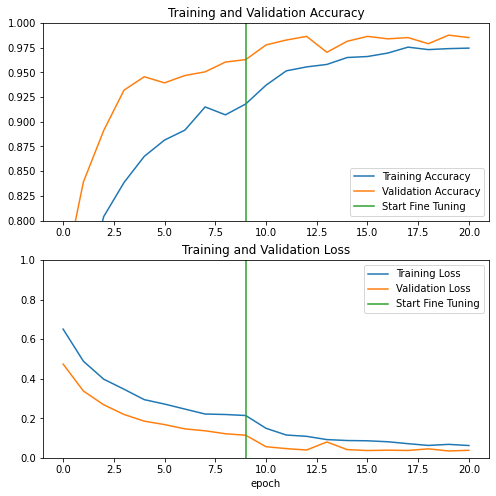

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Melakukan visualsi terhadap peningkatan pelatihan dan validasi model dengan plot pada model yang baru

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

Evaluasi model yang dibentuk dengan test dataset

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 58ms/step - loss: 0.0528 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Melakukan prediksi data test untuk melihat apakah gambar masuk ke dalam klasifikasi anjing atau kucing

Predictions:
 [0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0]
Labels:
 [0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0]


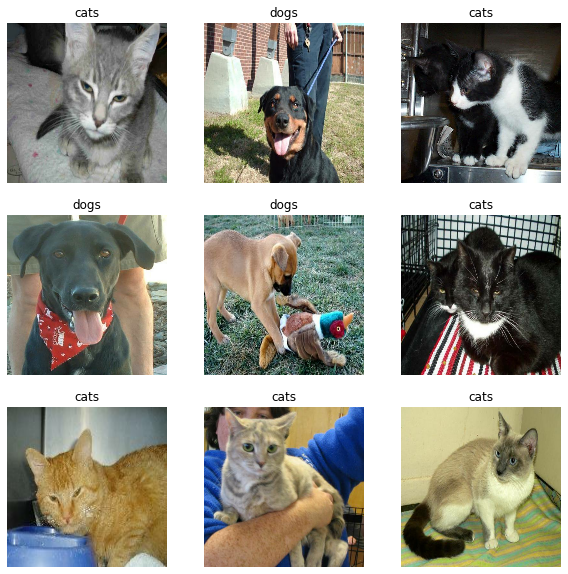

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


**Kesimpulan**
Pretrained model dengan feature extraction: Saat bekerja dengan kumpulan data kecil, merupakan praktik umum untuk memanfaatkan fitur yang dipelajari oleh model yang dilatih pada kumpulan data yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat instance model yang telah dilatih sebelumnya dan menambahkan classifier yang terhubung penuh di atasnya. Model pra-pelatihan "dibekukan" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusi mengekstrak semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih pengklasifikasi yang menentukan kelas gambar berdasarkan kumpulan fitur yang diekstraksi.

Fine tuning pada pre-trained model: Untuk lebih meningkatkan kinerja, seseorang mungkin ingin menggunakan kembali lapisan tingkat atas model pra-terlatih ke dataset baru melalui fine-tuning. Dalam hal ini, Anda menyetel bobot Anda sedemikian rupa sehingga model Anda mempelajari fitur tingkat tinggi khusus untuk kumpulan data. Teknik ini biasanya direkomendasikan ketika dataset pelatihan besar dan sangat mirip dengan dataset asli yang digunakan untuk melatih model pra-pelatihan.